# C.o.M. correction to Woods-Saxon radial wave functions

__Author:__ A. J. Tropiano [atropiano@anl.gov]<br/>
__Date:__ September 25, 2023

Compare Woods-Saxon radial wave functions and momentum distributions with and without the C.o.M. correction $r' \rightarrow \sqrt{\frac{A-1}{A}} r$.

_Last update:_ September 27, 2023

In [1]:
# Python imports
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.special import sph_harm, spherical_jn
from sympy.physics.quantum.cg import CG

In [2]:
# Imports from scripts
from scripts.figures import (
    set_rc_parameters, label_nlj_state, label_lambda, label_nucleus
)
from scripts.integration import momentum_mesh
from scripts.tools import replace_periods

In [3]:
# Run this cell to turn on customized matplotlib graphics
set_rc_parameters()

In [4]:
class SingleParticleState:
    """
    Single-particle state class. Packs together the following single-particle
    quantum numbers into one object.
    
    Parameters
    ----------
    n : int
        Principal quantum number n = 1, 2, ...
    l : int
        Orbital angular momentum l = 0, 1, ...
    j : float
        Total angular momentum j = 1/2, 3/2, ...
    m_j : float
        Total angular momentum projection m_j = -j, -j+1, ..., j.
    m_t : float
        Isospin projection m_t = 1/2 or -1/2.
    
    """
    
    
    def __init__(self, n, l, j, m_j, m_t):
        
        # Check if m_j is valid
        if abs(m_j) > j:
            raise RuntimeError("m_j is not valid.")
            
        # Check that |m_t| = 1/2
        if abs(m_t) != 1/2:
            raise RuntimeError("m_t is not valid.")
            
        self.n = n
        self.l = l
        self.j = j
        self.m_j = m_j
        self.m_t = m_t
        
        if m_t == 1/2:
            self.nucleon = 'proton'
        elif m_t == -1/2:
            self.nucleon = 'neutron'
        
        
    def __eq__(self, sp_state):

        if (
            self.n == sp_state.n and self.l == sp_state.l
            and self.j == sp_state.j and self.m_j == sp_state.m_j
            and self.m_t == sp_state.m_t
        ):
            
            return True
        
        else:
            
            return False
        
        
    def __str__(self):
        
        # Spectroscopic notation of orbital angular momentum
        l_str = convert_l_to_string(self.l)  # E.g., 's', 'p', 'd', ...
        
        # Display j subscript as a fraction
        numerator = 2*int(self.j) + 1
        denominator = 2

        return fr"${self.n}{l_str}_{{{numerator}/{denominator}}}$"

In [5]:
class WoodsSaxon:
    """
    Woods-Saxon orbitals class. Handles the radial wave functions associated
    with the Woods-Saxon potential from the subroutine in woodsaxon.f90. Outputs
    radial functions in coordinate and momentum space.
    
    Parameters
    ----------
    nucleus_name : str
        Name of the nucleus (e.g., 'O16', 'Ca40', etc.)
    Z : int
        Proton number of the nucleus.
    N : int
        Neutron number of the nucleus.
    run_woods_saxon : bool, optional
        Option to run the Woods-Saxon subroutine to generate orbital files.
    n_max : int, optional
        Maximum principal quantum number where n = 1, 2, ..., n_max.
    l_max : int, optional
        Maximum orbital angular momentum where l = 0, 1, ..., l_max.
    rmax : float, optional
        Maximum r for orbital tables.
    ntab : int, optional
        Number of points for orbital tables.
        
    """
    
    
    def __init__(self, nucleus_name, Z, N, cg_table, rmax=40, ntab=2000,
                 kmax=10.0, kmid=2.0, ntot=120, com_correction=False):
        
        # Set instance attributes
        self.woods_saxon_directory = f"../data/woods_saxon/{nucleus_name}/"
        self.cg_table = cg_table
        self.A = int(Z + N)

        # Order single-particle states with lowest energy first
        self.order_sp_states(Z, N)
        
        # Organize wave functions in dictionary
        self.sp_wfs = {}
        for sp_state in self.sp_states:
            
            # Wave functions are independent of m_j, so fix m_j=j
            if sp_state.m_j == sp_state.j:
                
                file_name = self.get_orbital_file_name(sp_state)
 
                data = np.loadtxt(self.woods_saxon_directory + file_name)
                
                # Use n, l, j, m_t as the key
                key = (sp_state.n, sp_state.l, sp_state.j, sp_state.m_t)
                self.sp_wfs[key] = data[:, 1]
                
        # r_array and dr are the same for every s.p. state
        self.r_array = data[:, 0]
        self.dr = max(self.r_array) / len(self.r_array)
        
        # Interpolate occupied s.p. wave functions w.r.t. momentum k
        self.interpolate_wavefunctions(kmax, kmid, ntot, com_correction)
        
        
    def get_orbital_file_name(self, sp_state):
        """Returns the file name of the orbital."""
            
        # Proton
        if sp_state.m_t == 1/2:
            file_name = (f"p.n{int(sp_state.n-1)}.l{int(sp_state.l)}"
                         f".j{int(2*sp_state.j)}.orb")
        # Neutron
        elif sp_state.m_t == -1/2:
            file_name = (f"n.n{int(sp_state.n-1)}.l{int(sp_state.l)}"
                         f".j{int(2*sp_state.j)}.orb")
            
        return file_name
        
        
    def order_sp_states(self, Z, N):
        """Keep track of all s.p. states and occupied s.p. states"""

        self.sp_states = []  # All single-particle states
        self.occupied_states = []  # Occupied single-particle states < E_F
        proton_count = 0
        neutron_count = 0
        
        # File with details of the orbitals
        ws_file = self.woods_saxon_directory + "ws_log"
    
        # Order single-particle states using the ws_log file
        with open(ws_file, 'r') as f:
            for line in f:
                unit = line.strip().split()
                
                # Protons
                if len(unit) > 0 and unit[0] == '1':

                    j = int(unit[3])/2
                    for m_j in np.arange(-j, j+1, 1):
                        sp_state = SingleParticleState(
                            int(unit[1])+1, int(unit[2]), j, m_j, 1/2
                        )  # n, l, j, m_j, m_t
                    
                        self.sp_states.append(sp_state)
                    
                        if proton_count < Z:
                            self.occupied_states.append(sp_state)
                            # Add up filled proton states
                            proton_count += 1
                    
                
                # Neutrons
                elif len(unit) > 0 and unit[0] == '2':

                    j = int(unit[3])/2
                    for m_j in np.arange(-j, j+1, 1):
                        sp_state = SingleParticleState(
                            int(unit[1])+1, int(unit[2]), j, m_j, -1/2
                        )  # n, l, j, m_j, m_t
                    
                        self.sp_states.append(sp_state)
                    
                        if neutron_count < N:
                            self.occupied_states.append(sp_state)
                            # Add up filled neutron states
                            neutron_count += 1


    def get_wf_rspace(
            self, sp_state, print_normalization=False, com_correction=False):
        """Single-particle wave function in coordinate space."""
        
        # n, l, j, m_t
        key = (sp_state.n, sp_state.l, sp_state.j, sp_state.m_t) 
        u_array = self.sp_wfs[key]

        # Normalization: \int dr |u(r)|^2 = 1
        if print_normalization:
            normalization = np.sum(self.dr * u_array ** 2)
            print(f"Coordinate space normalization = {normalization}.")
        
        # Return r and u(\sqrt((A-1)/A)*r)
        if com_correction:
            
            u_func = InterpolatedUnivariateSpline(self.r_array, u_array)
            A = self.A
            u_com_array = (((A-1)/A) ** (1/4)
                           * u_func(np.sqrt((A-1)/A) * self.r_array))
            
            # TESTING
#             norm = np.sum(self.dr * u_com_array ** 2)
#             print(norm)

            return self.r_array, u_com_array
        
        # Return r and u(r)
        else:

            return self.r_array, u_array
    
    
    def fourier_transformation(self, l, r_array, k_array):
        """Fourier transformation matrix for given orbital angular momentum."""
        
        # r_array column vectors and k_array row vectors where both grids are
        # n x m matrices
        r_cols, k_rows = np.meshgrid(r_array, k_array)
        
        # Transformation matrix with shape n x m, where m is the length of
        # r_array and n is the length of the k_array
        M = 1j ** (-l) * np.sqrt(2/np.pi) * self.dr * r_cols * spherical_jn(
            l, k_rows*r_cols
        )
        
        return M
    
    
    def get_wf_kspace(
            self, sp_state, kmax, kmid, ntot, print_normalization=False,
            interpolate=False, com_correction=False
    ):
        """Single-particle wave function in momentum space."""
    
        # Set momentum mesh with more points at low momentum
        k_array, k_weights = momentum_mesh(kmax, kmid, ntot)
    
        # Get coordinate-space s.p. wave function
        r_array, u_array = self.get_wf_rspace(sp_state,
                                              com_correction=com_correction)

        # Fourier-transform the wave function to momentum space
        phi_array = (self.fourier_transformation(sp_state.l, r_array, k_array)
                     @ u_array)
    
        # Normalization: \int dk k^2 |\phi(k)|^2 = 1
        if print_normalization:
            normalization = np.sum(k_weights * k_array ** 2
                                   * abs(phi_array) ** 2)
            print(f"Momentum space normalization = {normalization}.")
            
        # Interpolate and return function?
        if interpolate:
            
            if sp_state.l % 2 == 0:  # Even l
                
                phi_func = InterpolatedUnivariateSpline(k_array, phi_array.real)
                
            else:  # Odd l
            
                phi_func = InterpolatedUnivariateSpline(k_array, phi_array.imag)
                
            return phi_func
        
        # Otherwise return momentum, weights, and \phi(k)
        else:
            return k_array, k_weights, phi_array
        
        
    def interpolate_wavefunctions(self, kmax, kmid, ntot, com_correction=False):
        """Create dictionary of \phi(k) interpolated functions where the key
        is the single-particle state.
        """
        
        # Organize interpolated wave functions in dictionary with s.p. quantum
        # numbers as the key
        self.phi_functions = {}
        
        for sp_state in self.occupied_states:
            
            key = (sp_state.n, sp_state.l, sp_state.j, sp_state.m_t)
            self.phi_functions[key] = self.get_wf_kspace(
                sp_state, kmax, kmid, ntot, interpolate=True,
                com_correction=com_correction
            )
            
    
    def psi(self, sp_state, k, theta, phi, sigma, tau):
        """Single-particle wave function \psi_\alpha(k_vector; \sigma, \tau)."""

        # Calculate \phi_\alpha(k)
        key = (sp_state.n, sp_state.l, sp_state.j, sp_state.m_t)
        if sp_state.l % 2 == 0:  # Even l
            phi_sp_wf = self.phi_functions[key](k)
        else:  # Odd l needs factor of i^-l
            phi_sp_wf = 1j ** (-sp_state.l) * self.phi_functions[key](k)
    
        # Calculate spinor spherical harmonic
        Y_jml = self.spinor_spherical_harmonic(sp_state.l, sp_state.j,
                                               sp_state.m_j, theta, phi, sigma)
    
        # Isospinor indexed by \tau \chi_{m_t}(\tau)
        chi_tau = kronecker_delta(tau, sp_state.m_t)

        return phi_sp_wf * Y_jml * chi_tau
    

    def spinor_spherical_harmonic(self, l, j, m_j, theta, phi, sigma):
        """Spinor spherical harmonic for a s.p. state described by the quantum
        numbers j, m_j, l, and s=1/2.
        """
        
        # Spinor indexed by \sigma \eta_{m_s}^(\sigma) = \delta_{m_s, \sigma}
        m_s = sigma
    
        # m_l must be fixed since m_j and m_s are determined
        m_l = m_j - m_s
        
        # Check that |m_l| <= l
        if np.abs(m_l) <= l:
        
            # Clebsch-Gordan coefficient for l-s coupling
            cg = self.cg_table[(l, m_l, 1/2, m_s, j, m_j)]
        
            # Spherical harmonic
            Y_lm = sph_harm(m_l, l, phi, theta)
            
            return cg * Y_lm
        
        else:
            
            return 0+0j

In [6]:
def kronecker_delta(x, y):
    """Kronecker \delta function: \delta_{x,y}."""
    
    return int(x == y)

In [7]:
def compute_clebsch_gordan_table(j_max):
    """
    Calculate Clebsch-Gordan coefficients for combinations of j and m_j up
    to j_max.
    
    Parameters
    ----------
    j_max : int
        Maximum j value for j_1, j_2, and j_3. This also constrains m_j.
    
    Returns
    -------
    cg_table : dict
        Table of Clebsch-Gordan coefficients <j_1 m_j_1 j_2 m_j_2|j_3 m_j_3>
        for each combination of angular momenta.
        
    """
        
    cg_table = {}
        
    j_array = np.arange(0, j_max+1/2, 1/2)
    
    for j_1 in j_array:
        for j_2 in j_array:
            j_3_array = np.arange(abs(j_1-j_2), j_1+j_2+1)
            for j_3 in j_3_array:
                for m_1 in np.arange(-j_1, j_1+1, 1):
                    for m_2 in np.arange(-j_2, j_2+1, 1):
                        
                        m_3 = m_1 + m_2
                        
                        if abs(m_3) <= j_3:
                            cg_table[(j_1, m_1, j_2, m_2, j_3, m_3)] = float(
                                CG(j_1, m_1, j_2, m_2, j_3, m_3).doit()
                            )
                            
    print(f"Done calculating Clebsch-Gordan table up to j_max = {j_max}.")
                                
    return cg_table

In [8]:
def compute_I_term(q_array, tau, woods_saxon):
    """Compute the I * n(q) * I term."""
        
    I_array = np.zeros_like(q_array)
    theta_array = np.zeros_like(q_array)
    phi_array = np.zeros_like(q_array)
        
    # Loop over spin projections
    for sigma in np.array([1/2, -1/2]):
            
        # Loop over occupied s.p. states
        for alpha in woods_saxon.occupied_states:

            # Single-particle wave function with z-axis along q_vector
            psi_alpha_array = woods_saxon.psi(alpha, q_array, theta_array,
                                              phi_array, sigma, tau)

            I_array += np.abs(psi_alpha_array) ** 2
                    
    return I_array

In [9]:
def load_momentum_distribution(nucleus_name, nucleon, kvnn, lamb,
                               com_correction=False):
    """Load and return the momentum distribution along with the isolated
    contributions.
    """
    
    directory = 'momentum_distributions/'

    if com_correction:
        file_name = replace_periods(
            f"{nucleus_name}_{nucleon}_momentum_distribution_kvnn_{kvnn}"
            f"_lamb_{lamb}_com_correction"
        )
    else:
        file_name = replace_periods(
            f"{nucleus_name}_{nucleon}_momentum_distribution_kvnn_{kvnn}"
            f"_lamb_{lamb}"
        )
    
    data = np.loadtxt(directory + file_name + '.txt')
    
#     q_array = data[:, 0]
#     q_weights = data[:, 1]
#     n_array = data[:, 2]
#     n_errors = data[:, 3]
#     I_array = data[:, 4]
#     delta_U_array = data[:, 5]
#     delta_U_errors = data[:, 6]
#     delta_U2_array = data[:, 7]
#     delta_U2_errors = data[:, 8]
    
    return data

In [10]:
# Set table of Clebsch-Gordan coefficients
jmax = 5  # This should cover nuclei as heavy as 208Pb
cg_table = compute_clebsch_gordan_table(jmax)

Done calculating Clebsch-Gordan table up to j_max = 5.


The C.o.M. correction for momentum distributions using HO wave functions is simply taking $b'=\sqrt{\frac{A}{A-1}}b$.

HO wave functions depend on the ratio $\frac{r}{b}$, thus the dependence on $\frac{r}{b}$ goes to $\sqrt{\frac{A-1}{A}} \frac{r}{b}$.

We make an approximation to this correction using Woods-Saxon radial functions by taking $r \rightarrow \sqrt{\frac{A-1}{A}} r$.

Corrected radial wave functions are

$$
u'_{nlj}(r) \equiv (\frac{A-1}{A})^{1/4}\, u_{nlj}(\sqrt{\frac{A-1}{A}} r)
$$

where the factor of $(\frac{A-1}{A})^{1/4}$ is to ensure normalization to $1$.

The normalizations are given below:

$$
1 = \int_0^\infty dr\, \lvert u_{nlj}(r) \rvert^2
$$

$$
1 = \int_0^\infty dr\, \lvert (\frac{A-1}{A})^{1/4}\, u_{nlj}(\sqrt{\frac{A-1}{A}} r) \rvert^2
$$

## Woods-Saxon radial wave functions

In [11]:
def plot_sp_wfs_rspace(
        nucleus_name, Z, N, sp_state, x_limits=(0.0,10.0), y_limits=(0.0,0.8)
):
    """Plot the s.p. wave functions of a nucleus in coordinate space."""
    
    woods_saxon = WoodsSaxon(nucleus_name, Z, N, cg_table)
    
    # u(r)
    r_array, u_array = woods_saxon.get_wf_rspace(sp_state, com_correction=False)
    # u(\sqrt((A-1)/A)*r)
    r_array, u_com_array = woods_saxon.get_wf_rspace(sp_state,
                                                     com_correction=True)

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 4))
    
    # Plot both
    ax.plot(r_array, u_array, linewidth=2.0, label=r"$u(r)$")
    ax.plot(r_array, u_com_array, linewidth=2.0,
            label=r"$(\frac{A-1}{A})^{1/4} u(\sqrt{\frac{A-1}{A}}r)$")
    
    # PRINT NORMALIZATION
    print(np.sum(woods_saxon.dr * u_array ** 2))
    print(np.sum(woods_saxon.dr * u_com_array ** 2))

    # Set axes limits
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # Set axes labels
    ax.set_xlabel(r"$r$ [fm]", fontsize=16)
    ax.set_ylabel(r"proton $u(r)$ [fm" + r'$^{-1/2}$' + ']', fontsize=16)

    # Set legend
    ax.legend(loc='upper right', fontsize=12, frameon=False)

    # Add nucleus label
    ax.add_artist(
        AnchoredText(label_nlj_state(sp_state.n, sp_state.l, sp_state.j),
                     loc='lower right', prop=dict(size=18), frameon=False)
    )
    ax.set_title(label_nucleus(nucleus_name), fontsize=16)
    
    plt.plot()

1.0000000000359839
0.999999999681236


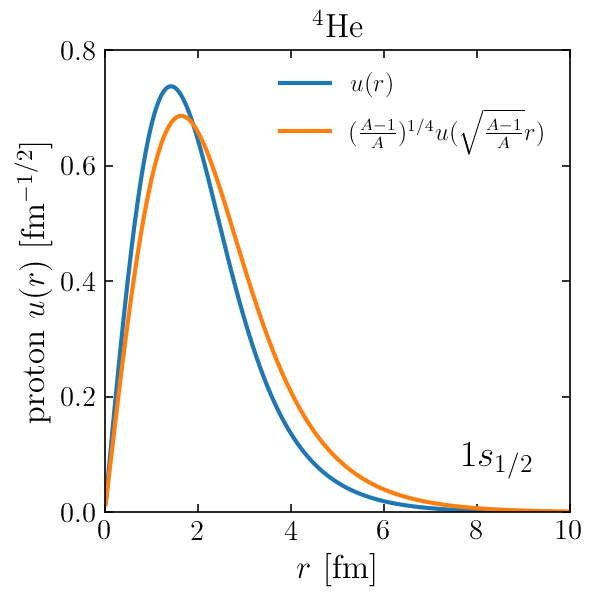

In [12]:
nucleus_name, Z, N = 'He4', 2, 2
sp_state = SingleParticleState(1, 0, 1/2, 1/2, 1/2)  # 1s_{1/2}

plot_sp_wfs_rspace(nucleus_name, Z, N, sp_state)

## Woods-Saxon radial functions in momentum space

In [13]:
def plot_sp_wfs_kspace(
        nucleus_name, Z, N, sp_state, x_limits=(0.0,5.0), y_limits=(-0.1,4.0)
):
    """Plot the s.p. wave functions of a nucleus in coordinate space."""
    
    woods_saxon = WoodsSaxon(nucleus_name, Z, N, cg_table)
    kmax, kmid, ntot = 10.0, 2.0, 120
    
    # F.T. of u(r)
    k_array, k_weights, phi_array = woods_saxon.get_wf_kspace(
        sp_state, kmax, kmid, ntot, print_normalization=True,
        com_correction=False
    )
    # F.T. of u(\sqrt((A-1)/A)*r)
    k_com_array, k_com_weights, phi_com_array = woods_saxon.get_wf_kspace(
        sp_state, kmax, kmid, ntot, print_normalization=True,
        com_correction=True
    )

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 4))
    
    # Plot both
    ax.plot(k_array, np.abs(phi_array), linewidth=2.0, label=r"$\phi(k)$")
    ax.plot(k_com_array, np.abs(phi_com_array), linewidth=2.0,
            label=r"Corrected $\phi(k)$")

    # Set axes limits
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # Set axes labels
    ax.set_xlabel(r"$k$ [fm$^{-1}$]", fontsize=16)
    ax.set_ylabel(r"proton $|\phi(k)|$ [fm" + r'$^{3/2}$' + ']', fontsize=16)

    # Set legend
    ax.legend(loc='upper right', fontsize=12, frameon=False)

    # Add nucleus label
    ax.add_artist(
        AnchoredText(label_nlj_state(sp_state.n, sp_state.l, sp_state.j),
                     loc='lower right', prop=dict(size=18), frameon=False)
    )
    ax.set_title(label_nucleus(nucleus_name), fontsize=16)
    
    plt.plot()

Momentum space normalization = 1.0000000000276592.
Momentum space normalization = 0.9999999996788984.


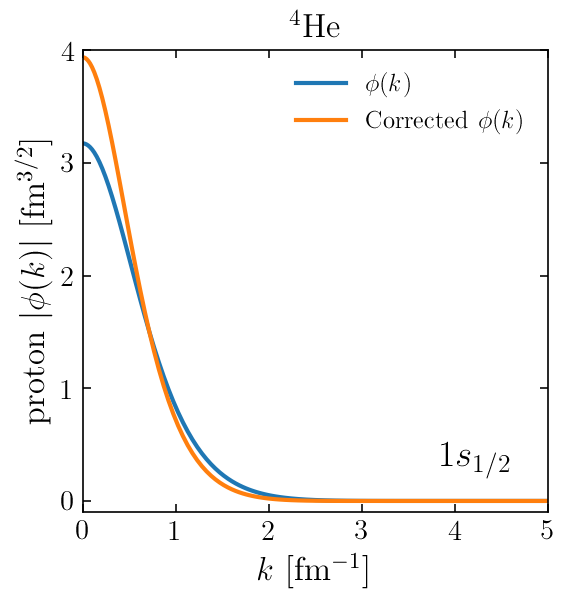

In [14]:
nucleus_name, Z, N = 'He4', 2, 2
sp_state = SingleParticleState(1, 0, 1/2, 1/2, 1/2)  # 1s_{1/2}

plot_sp_wfs_kspace(nucleus_name, Z, N, sp_state)

## Independent-particle model momentum distribution

In [15]:
def plot_ipm_momentum_distribution(
        nucleus_name, Z, N, x_limits=(0.0,3.0), y_limits=(1e-3,1e3),
        y_scale='log', show_vmc=False
):
    """Plot the IPM momentum distributions."""
    
    woods_saxon = WoodsSaxon(nucleus_name, Z, N, cg_table)
    woods_saxon_com = WoodsSaxon(nucleus_name, Z, N, cg_table,
                                 com_correction=True)
    
    q_array = np.linspace(0.0, 4.0, 200)
    n_ipm_array = compute_I_term(q_array, 1/2, woods_saxon)
    n_ipm_com_array = compute_I_term(q_array, 1/2, woods_saxon_com)
    
    # Multiply by factor of (2\pi)^3 to compare to VMC
    n_ipm_array *= (2*np.pi) ** 3
    n_ipm_com_array *= (2*np.pi) ** 3

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 4))
    
    if y_scale == 'log':
        ax.set_yscale('log')
    else:
        ax.set_yscale('linear')
        
    # Compare to VMC calculation?
    if show_vmc:
        
        file_name = f"{nucleus_name}_single_nucleon.txt"
        data = np.loadtxt('../data/vmc/momentum_distributions/' + file_name)
        q_array_vmc = data[:,0]
        n_array_vmc = data[:,1]
        n_errors_vmc = data[:,2]
        
        if y_scale == 'linear':
            ax.errorbar(
                q_array_vmc, n_array_vmc * q_array_vmc **2 , yerr=n_errors_vmc,
                color='black', label='VMC', linestyle='', marker='.', zorder=3
            )
        else:
            ax.errorbar(
                q_array_vmc, n_array_vmc, yerr=n_errors_vmc, color='black',
                label='VMC', linestyle='', marker='.', zorder=3
            )
    
    # Log scale
    if y_scale == 'log':
        ax.plot(q_array, n_ipm_array, linewidth=2.0, label="IPM: No correction",
                zorder=2)
        ax.plot(q_array, n_ipm_com_array, linewidth=2.0,
                label="IPM: CoM correction", zorder=1)
    elif y_scale == 'linear':
        ax.plot(q_array, n_ipm_array * q_array ** 2, linewidth=2.0,
                label="IPM: No correction", zorder=2)
        ax.plot(q_array, n_ipm_com_array * q_array ** 2, linewidth=2.0,
                label="IPM: CoM correction", zorder=1)

    # Set axes limits
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # Set axes labels
    ax.set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
    if y_scale == 'linear':
        ylabel = r"$q^2 n_{p}(q)$ [fm]"
    elif y_scale == 'log':
        ylabel = r"$n_{p}(q)$ [fm" + r'$^3$' + ']'
    ax.set_ylabel(ylabel, fontsize=16)

    # Set legend
    ax.legend(loc='upper right', fontsize=10, frameon=False)

    # Add nucleus label
    ax.add_artist(
        AnchoredText(label_nucleus(nucleus_name), loc='center right',
                     prop=dict(size=18), frameon=False)
    )
    
    plt.plot()

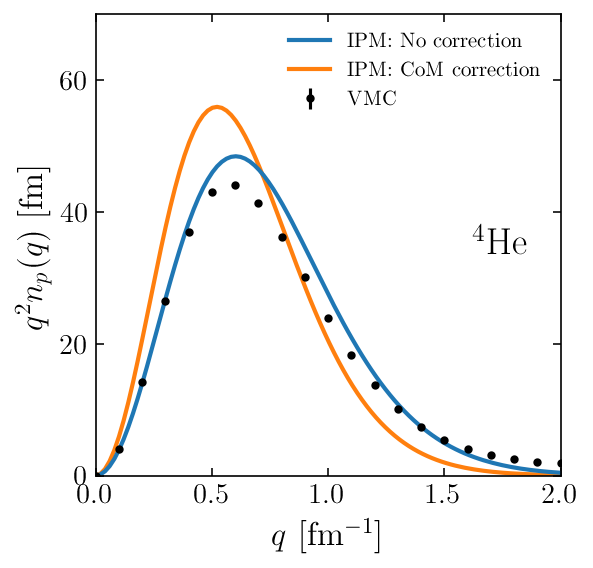

In [16]:
plot_ipm_momentum_distribution(
    'He4', 2, 2, x_limits=(0.0, 2.0), y_limits=(-0.1, 70.0), y_scale='linear',
    show_vmc=True
)

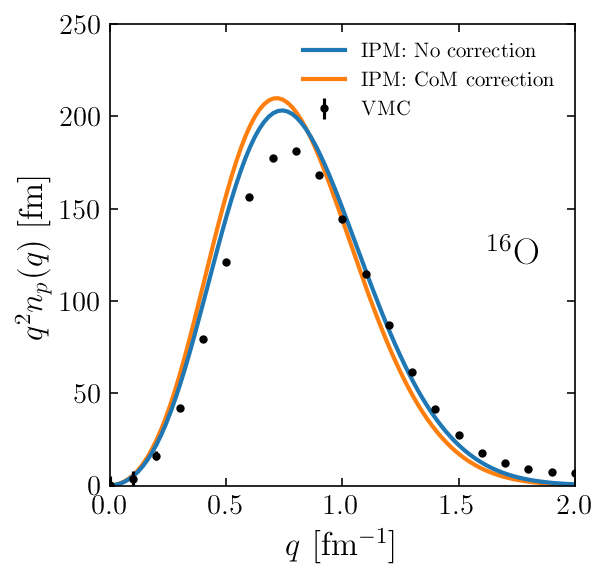

In [17]:
plot_ipm_momentum_distribution(
    'O16', 8, 8, x_limits=(0.0, 2.0), y_limits=(-0.5, 250.0), y_scale='linear',
    show_vmc=True
)

## Full momentum distribution

In [18]:
def plot_momentum_distribution(
        nucleus_name, Z, N, kvnn=6, lamb=1.5, x_limits=(0.0,6.0),
        y_limits=(1e-3,1e3), y_scale='log', show_vmc=False
):
    """Plot the IPM momentum distributions."""
    
    # Load data from file
    data = load_momentum_distribution(nucleus_name, 'proton', kvnn, lamb)
    com_data = load_momentum_distribution(nucleus_name, 'proton', kvnn, lamb,
                                          com_correction=True)
    
    # Multiply by factor (2\pi)^3 to compare to VMC data
    q_array = data[:, 0]
    n_array = (2*np.pi) ** 3 * data[:, 2]
    n_ipm_array = (2*np.pi) ** 3 * data[:, 4]
    q_com_array = com_data[:, 0]
    n_com_array = (2*np.pi) ** 3 * com_data[:, 2]
    n_com_ipm_array = (2*np.pi) ** 3 * com_data[:, 4]
#     # TESTING
#     A = Z + N
#     n_com_ipm_array = (2*np.pi) ** 3 * com_data[:, 4] * (A/(A-1)) ** (1/2)
#     n_com_delU_array = (2*np.pi) ** 3 * com_data[:, 5] * A/(A-1)
#     n_com_delU2_array = (2*np.pi) ** 3 * com_data[:, 7] * A/(A-1)
#     n_com_array = n_com_ipm_array + n_com_delU_array + n_com_delU2_array
    
    # PRINT NORMALIZATION OF CORRECTED DISTRIBUTION
    print(4*np.pi/(2*np.pi) ** 3
          * np.sum(com_data[:, 1] * q_com_array ** 2 * n_com_array))

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 4))
    
    if y_scale == 'log':
        ax.set_yscale('log')
    else:
        ax.set_yscale('linear')
        
    # Compare to VMC calculation?
    if show_vmc:
        
        file_name = f"{nucleus_name}_single_nucleon.txt"
        data = np.loadtxt('../data/vmc/momentum_distributions/' + file_name)
        q_array_vmc = data[:,0]
        n_array_vmc = data[:,1]
        n_errors_vmc = data[:,2]
        
        if y_scale == 'linear':
            ax.errorbar(
                q_array_vmc, n_array_vmc * q_array_vmc **2 , yerr=n_errors_vmc,
                color='black', label='VMC', linestyle='', marker='.', zorder=5
            )
        else:
            ax.errorbar(
                q_array_vmc, n_array_vmc, yerr=n_errors_vmc, color='black',
                label='VMC', linestyle='', marker='.', zorder=5
            )
    
    # Log scale
    if y_scale == 'log':
        
        # IPM without correction
        ax.plot(q_array, n_ipm_array, linewidth=2.0, label="IPM",
                linestyle='dotted', zorder=1)
        
        # IPM with correction
        ax.plot(q_com_array, n_com_ipm_array, linewidth=2.0,
                label="IPM corrected", linestyle='dotted', zorder=2)
        
        # Full distribution without correction
        ax.plot(q_array, n_array, linewidth=2.0, label="SRG", zorder=3)

        # Full distribution with correction
        ax.plot(q_com_array, n_com_array, linewidth=2.0, label="SRG corrected",
                zorder=4)

    elif y_scale == 'linear':
        
        # IPM without correction
        ax.plot(q_array, n_ipm_array * q_array ** 2, linewidth=2.0,
                label="IPM", linestyle='dotted', zorder=1)
        
        # IPM with correction
        ax.plot(q_com_array, n_com_ipm_array * q_com_array ** 2, linewidth=2.0,
                label="IPM corrected", linestyle='dotted', zorder=2)
        
        # Full distribution without correction
        ax.plot(q_array, n_array * q_array ** 2, linewidth=2.0, label="SRG",
                zorder=3)

        # Full distribution with correction
        ax.plot(q_com_array, n_com_array * q_com_array ** 2, linewidth=2.0,
                label="SRG corrected", zorder=4)

    # Set axes limits
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # Set axes labels
    ax.set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
    if y_scale == 'linear':
        ylabel = r"$q^2 n_{p}(q)$ [fm]"
    elif y_scale == 'log':
        ylabel = r"$n_{p}(q)$ [fm" + r'$^3$' + ']'
    ax.set_ylabel(ylabel, fontsize=16)

    # Set legend
    ax.legend(loc='upper right', fontsize=10, frameon=False)

    # Add nucleus label
    ax.add_artist(
        AnchoredText(label_nucleus(nucleus_name), loc='center right',
                     prop=dict(size=18), frameon=False)
    )
    
    # Label \lambda
    ax.set_title(label_lambda(lamb), fontsize=16)
    
    plt.plot()

### $^4$He at $\lambda = 1.5\,\rm{fm}^{-1}$

1.9996278672079992


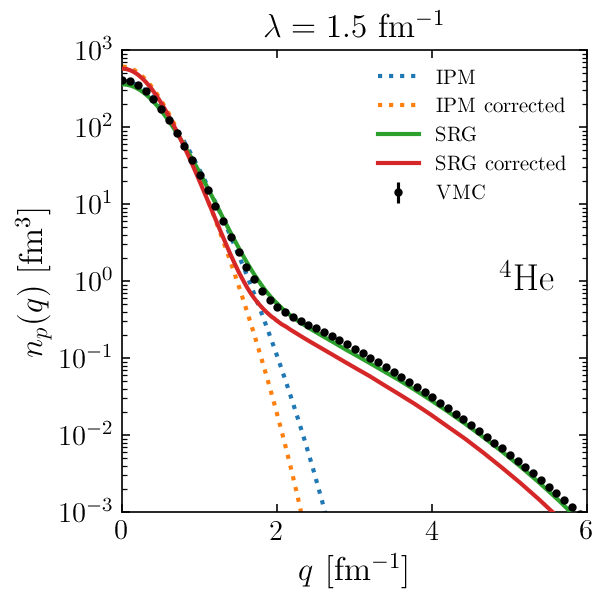

In [19]:
# Compare 4He with and without correction (showing VMC as well)
nucleus_name, Z, N = 'He4', 2, 2

plot_momentum_distribution(nucleus_name, Z, N, y_scale='log', show_vmc=True)

1.9996278672079992


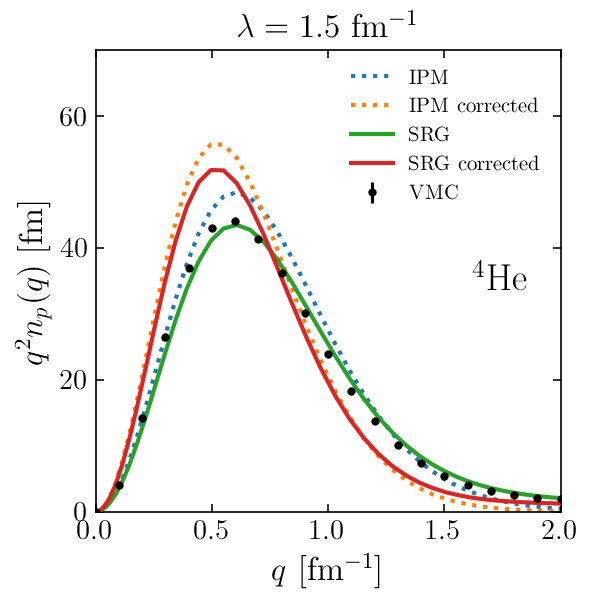

In [20]:
plot_momentum_distribution(
    nucleus_name, Z, N, x_limits=(0.0, 2.0), y_limits=(-0.1, 70.0),
    y_scale='linear', show_vmc=True
)

### $\lambda = 1.35\,\rm{fm}^{-1}$

1.9998772738482473


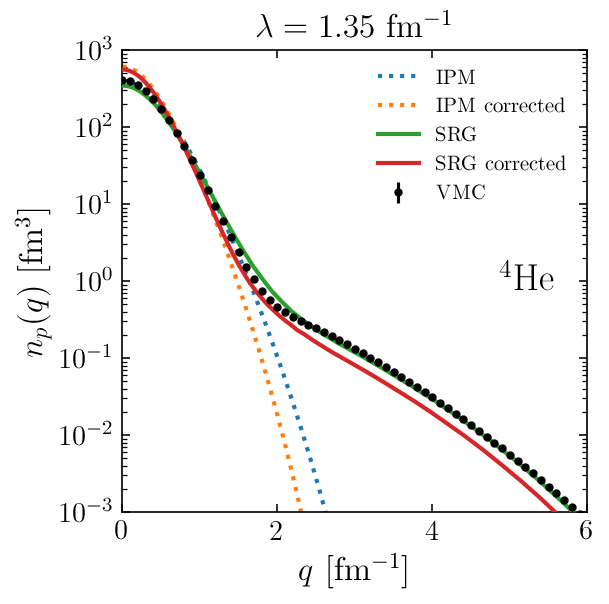

In [21]:
plot_momentum_distribution(nucleus_name, Z, N, lamb=1.35, y_scale='log',
                           show_vmc=True)

1.9998772738482473


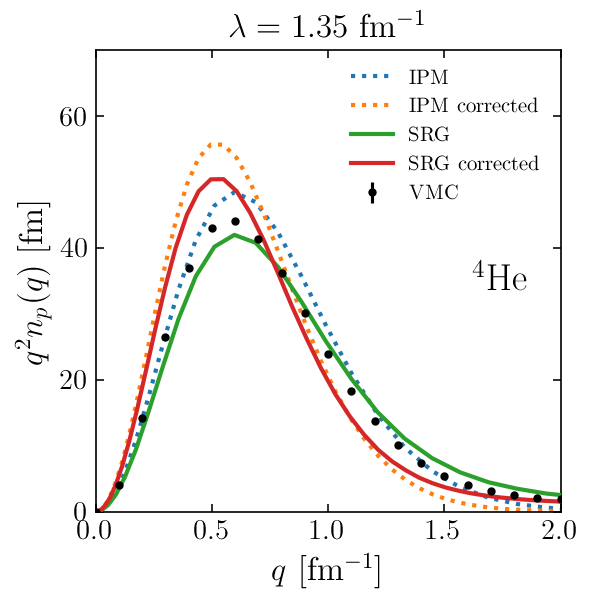

In [22]:
plot_momentum_distribution(
    nucleus_name, Z, N, lamb=1.35, x_limits=(0.0, 2.0), y_limits=(-0.1, 70.0),
    y_scale='linear', show_vmc=True
)

### $^{16}$O at $\lambda = 1.5\,\rm{fm}^{-1}$

7.993916690272728


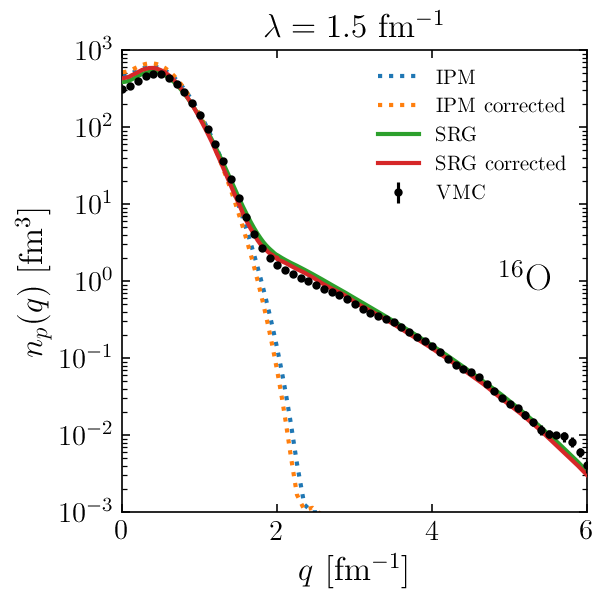

In [23]:
# Same but for 16O
nucleus_name, Z, N = 'O16', 8, 8

plot_momentum_distribution(nucleus_name, Z, N, y_scale='log', show_vmc=True)

7.993916690272728


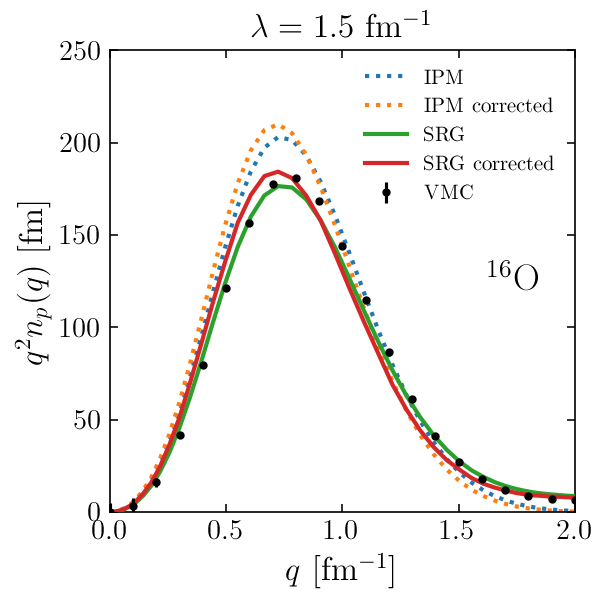

In [25]:
plot_momentum_distribution(
    nucleus_name, Z, N, x_limits=(0.0, 2.0), y_limits=(-0.1, 250.0),
    y_scale='linear', show_vmc=True
)